# Introdução ao Problema

Imagine que o plano mensal de um provedor de internet seja 50 RS com instalação grátis. Supondo que o modem tenha um custo de 300 RS, demoraria 6 meses para a empresa apenas recuperar o valor que foi gasto na aquisição desse novo cliente. 
Caso ele venha por algum motivo a deixar de assinar o serviço antes desse período, seu valor gerado seria menor que o custo, levando a um o retorno sobre o investimento negativo. 
A esse problema é dado o nome de rotatividade de clientes, ou churn, bastante frequente em empresas que oferecem serviços por assinatura onde o custo de aquisição de clientes é alto em relação ao valor da mensalidade.
Reduzir a taxa de churn é essencial para manutenção de um balanço financeiro saudável, pois de nada adianta conquistar vários clientes se os mesmos não permanecem na empresa. Além disso, repor um cliente rotativo é em média 5x mais caro do que manter esse mesmo cliente na compainha.

# Objetivos

- Entender fatores que ocasionam o churn em empresas de telecomunicação
- Fornecer insights e sugestões, baseadas em dados, que auxiliem os tomadores de decisão a aumentar a retenção de clientes
- Treinar um modelo de Machine Learning para prever a probabilidade de um cliente vir a abandonar a empresa
- Segmentar os clientes em grupos com base em seu comportamento
- Realizar o deploy


# Importando Pacotes

In [23]:
# uso geral
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modelagem
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate,cross_val_predict
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel

#aprendizagem supervisionada
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#aprendizagem não-supervisionada
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#tunning de hiperparãmetros
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

#avaliação do modelo
from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.classifier import DiscriminationThreshold, discrimination_threshold

# ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#serialização / deserialização
import pickle

import time

import shap

pd.options.display.float_format = '{:.2f}'.format

import matplotlib.patches as mpatches

#import utils_fun
#import utils_classes

from sklearn.calibration import calibration_curve, CalibrationDisplay

from sklearn.base import clone

from imblearn.pipeline import make_pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

## Classes e Funções Auxiliares

### EDA - State

In [16]:
RotationPropState().head()

,state,churn,count,totalState,prop
4,CA,yes,14,52,26.92
31,NJ,yes,28,112,25.00
47,WA,yes,24,98,24.49
43,TX,yes,26,116,22.41
26,MT,yes,21,99,21.21


In [ ]:
BarplotState(churn_state_prop, y = "prop", y_label = "Proporção de Churn (%)", title = "Taxa de Evasão por Estado", bars_annotate = True)

In [3]:
#Definindo funções auxiliares de plotagem e manipulação de dataframes

def SumFeatureState(feature):
    
    """Função que calcula o total de uma feature por estado
    Recebe: feature numérica do dataframe explore
    Retorna: dataframe com duas colunas (Estado e Soma Agregada)
    """
    
    df_sum_state = explore.groupby("state")[feature].sum().reset_index().sort_values(by = feature, ascending = False)
    return df_sum_state



def CountGroupState():
    
    """ Função que calcula o numéro de clientes que fizeram ou não churn por estado 
    Retorna: Dataframe com 3 colunas (Estado, Fez ou Não Churn e Contagem)
    """
    
    df_state = explore.groupby(["state","churn"]).count().iloc[:,0].reset_index().rename(columns = {"account_length":"count"})
    return df_state


def RotationPropState():
    
    """ Função que calcula a proporção de clientes que fizeram churn em cada estado
    Retorna: Dataframe com 5 colunas (Estado, Churn (todos = yes), Número de clientes 
    que fizeram churn por estado, Total de Clientes por estado e Taxa de Churn por estado)
    """
    
    stateChurn = CountGroupState()
    yes_stateChurn = stateChurn[stateChurn["churn"] == "yes"]
    lenState = explore["state"].value_counts().reset_index().rename(columns={"index":"state", "state":"totalState"})
    stateProp = pd.merge(left=yes_stateChurn, right=lenState, on="state")
    stateProp["prop"] = ((stateProp["count"] / stateProp["totalState"])*100).round(2)
    stateProp = stateProp.sort_values(ascending=False, by= "prop")
    return stateProp


def BarplotState(data, y, y_label, title = None, bars_annotate = False):
    
    """ Função que plota um gráfico de barras com os estados 
    no eixo X e qualquer outra variável no eixo Y
    Recebe: data (Dataframe), y: feature numérica do df (string), 
    y_label: nome do eixo y no gráfico (string), title: Título do gráfico (string),
    bars_annotate: mostrar ou não totais em cada barra (bool)
    """
    
    plt.figure(figsize=(20,10))
    plt.title(title)

    ax = sns.barplot(data=data, x = "state", y = y, color="blue")
    ax.set_ylabel(y_label)
    ax.set_xlabel("Estado")
    
    if bars_annotate == True:
        for p in ax.patches:ax.annotate(format(p.get_height(), '.0f'), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', va = 'center', xytext = (0, 9),
        textcoords = 'offset points')
        
    plt.grid(False)


def StackedBarplotState():
    
    """Função que plota um gráfico de barras stacked contendo o total de clientes por estado 
    e quantos deles realizaram o churn"""


    df_plot = churn_state_prop.sort_values(by = "totalState", ascending = False)

    plt.figure(figsize = (20,12))
    plt.title("Total de Clientes por Estado")

    bar1 = sns.barplot(data = df_plot, x  = "state", y = "totalState", color = "lightblue")
    bar2 = sns.barplot(data = df_plot, x = "state", y = "count", color = "darkblue")

    bar1.set_ylabel("Total de Clientes")
    bar1.set_xlabel("Estado")

    for p in bar1.patches:
        bar1.annotate(format(p.get_height(), '.0f'), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha = 'center', va = 'center', 
        xytext = (0, 9), #9
        textcoords = 'offset points')

    top_bar = mpatches.Patch(color='darkblue', label='churn')
    bottom_bar = mpatches.Patch(color='lightblue', label='not churn')
    plt.legend(handles=[top_bar, bottom_bar])
    plt.grid(False)
    plt.show()

### Avaliação de Modelos

In [4]:
def grouped_barplot(categories, bar1, bar2, label1, label2, title, pos = 0 ):
    
    """Função que plota um grouped barplot
    Recebe: categories: categorias do eixo y (lista de strings),
    bar1: valores numéricos da 1a barra (lista de num),
    bar2: valores numéricos da 2a barra (lista de num),
    label1: legenda da barra 1 (string),
    label2: legenda da barra 2 (string), 
    title: titulo do grafico (string),
    pos: posição da legenda (0 a 4)"""
    
    x = np.arange(len(categories))
    width = 0.35
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, [round(i,4) for i in bar1], width, label = label1)
    rects2 = ax.bar(x + width/2, [round(i,4) for i in bar2], width, label = label2)

    ax.set_title(title)
    ax.set_xticks(x,labels)
    ax.legend(loc = pos)

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    fig.tight_layout()
    
    plt.show()

In [22]:
class evaluate_models:
    
    """Classe para comparar diferentes modelos utilizando a área sob 
    a curva precision-recall como métrica
    """
    
    def __init__(self, X_train, y_train, X_val, y_val):
        """Inicializando classe com atributos do tipo Dataframe"""
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
  
    def get_score(self, model_names, model_instances, transformer, folds):
        """ Função que avalia diferentes modelos nos dados de treino (validação cruzada) e
        nos dados de validação
        """
        self.model_names = model_names
        self.clas_reports = []
        self.train_scores = []
        self.val_scores = []

        start_time = time.time()

        for label, model in zip(self.model_names, model_instances):
        
            final_pipe = make_pipeline(transformer, model)
            probs_train = cross_val_predict(final_pipe, self.X_train, self.y_train, cv=folds, method="predict_proba", n_jobs=-1)[:,1]
            train_score = average_precision_score(self.y_train, probs_train)
            self.train_scores.append(train_score)
    
            final_pipe.fit(self.X_train,self.y_train)
            val_score = average_precision_score(self.y_val, final_pipe.predict_proba(self.X_val)[:,1])
            self.val_scores.append(val_score)

            clas_report = classification_report(y_val, final_pipe.predict(X_val), output_dict=True)
            self.clas_reports.append(clas_report)
    

        print(f"Tempo de execução: {(time.time() - start_time):.4f} segundos ---")

    def plot_scores(self):
        """ Plota em um gráfico de barras os resultados de AP em treino e e validação"""

        x = np.arange(len(self.model_names))
        width = 0.35

        fig,ax = plt.subplots()
        rects1 = ax.bar(x - width/2, [round(i,4) for i in self.train_scores], width, label='Train')
        rects2 = ax.bar(x + width/2, [round(i,4) for i in self.val_scores], width, label='Validation')

        ax.set_ylabel('Precisão Média (AP)')
        ax.set_title('Precisão Média em Treino (10 folds) e Validação')
        ax.set_xticks(x, self.model_names)
        ax.legend(loc = 2)

        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)

        fig.tight_layout()

        plt.show()
  
    def show_class_report(self):
        """ Função que plota um gráfico de barras com valores de recall e precision 
        para classe 1 (churn)
        """

        recalls = []
        precisions = []
        for i in range(len(self.model_names)):
            recalls.append(self.clas_reports[i]["1"]["recall"])
            precisions.append(self.clas_reports[i]["1"]["precision"])

        grouped_barplot(self.model_names, recalls,precisions,"Recall","Precision","Precisão e Recall nos dados de validação", 2)

### Column Transformer

Função retirada ed https://johaupt.github.io/blog/columnTransformer_feature_names.html

In [6]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline: #sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline: #sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

# Carregando os dados

Os datasets utilizados são os da competição Customer Churn Prediction 2020 do [Kaggle](https://www.kaggle.com/competitions/customer-churn-prediction-2020/data) com os dados de teste rotulados pela equipe da [Data Science Academy](https://www.datascienceacademy.com.br/). Deste modo, não é necessário submeter as predições ao Kaggle para obter a performance em teste.

In [7]:
train_raw = pd.read_csv("data/projeto4_telecom_treino.csv")
test_raw = pd.read_csv("data/projeto4_telecom_teste.csv")

In [8]:
#fazendo uma cópia dos dataframes originais
train = train_raw.copy()
test = test_raw.copy()

In [ ]:
#shape dos dados
print(f"Treino: {train.shape[0]} linhas e {train.shape[1]} colunas")
print(f"Teste: {test.shape[0]} linhas e {test.shape[1]} colunas")

Treino: 3333 linhas e 21 colunas
Teste: 1667 linhas e 21 colunas


Como os dados de teste já estão rotulados, unirei treino e teste apenas para análise exploratória, sem realizar nenhum pré-processamento a esse conjunto.Vale ressaltar que isso não é uma prática adequada em ambiente de produção, é importante pensar no conjunto de teste como dados não disponíveis "hoje" e que chegarão a empresa "amanhã" afim de evitar qualquer tipo de leakege. Portanto, nas etapas de modelagem para Machine Learning voltaremos a tratar treino e teste de forma separada.

In [9]:
#unindo treino e teste
explore = pd.concat([train, test])
explore.reset_index(inplace = True)

In [ ]:
explore.head()

,index,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,0,1,KS,128,area_code_415,no,yes,25,265.10,110,...,99,16.78,244.70,91,11.01,10.00,3,2.70,1,no
1,1,2,OH,107,area_code_415,no,yes,26,161.60,123,...,103,16.62,254.40,103,11.45,13.70,3,3.70,1,no
2,2,3,NJ,137,area_code_415,no,no,0,243.40,114,...,110,10.30,162.60,104,7.32,12.20,5,3.29,0,no
3,3,4,OH,84,area_code_408,yes,no,0,299.40,71,...,88,5.26,196.90,89,8.86,6.60,7,1.78,2,no
4,4,5,OK,75,area_code_415,yes,no,0,166.70,113,...,122,12.61,186.90,121,8.41,10.10,3,2.73,3,no


In [10]:
#removendo a variáveis ids
explore.drop(["index","Unnamed: 0"], axis = 1, inplace=True)

In [11]:
explore.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.10,110,45.07,197.40,99,16.78,244.70,91,11.01,10.00,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.60,123,27.47,195.50,103,16.62,254.40,103,11.45,13.70,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.40,114,41.38,121.20,110,10.30,162.60,104,7.32,12.20,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.40,71,50.90,61.90,88,5.26,196.90,89,8.86,6.60,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.70,113,28.34,148.30,122,12.61,186.90,121,8.41,10.10,3,2.73,3,no


In [ ]:
#verificando missing values
explore.isnull().sum().sum()

0

# Explorando os dados

In [ ]:
explore.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00
mean,100.26,7.76,180.29,100.03,30.65,200.64,100.19,17.05,200.39,99.92,9.02,10.26,4.44,2.77,1.57
std,39.69,13.55,53.89,19.83,9.16,50.55,19.83,4.30,50.53,19.96,2.27,2.76,2.46,0.75,1.31
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,73.00,0.00,143.70,87.00,24.43,166.38,87.00,14.14,166.90,87.00,7.51,8.50,3.00,2.30,1.00
50%,100.00,0.00,180.10,100.00,30.62,201.00,100.00,17.09,200.40,100.00,9.02,10.30,4.00,2.78,1.00
75%,127.00,17.00,216.20,113.00,36.75,234.10,114.00,19.90,234.70,113.00,10.56,12.00,6.00,3.24,2.00
max,243.00,52.00,351.50,165.00,59.76,363.70,170.00,30.91,395.00,175.00,17.77,20.00,20.00,5.40,9.00


In [ ]:
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          5000 non-null   object 
 1   account_length                 5000 non-null   int64  
 2   area_code                      5000 non-null   object 
 3   international_plan             5000 non-null   object 
 4   voice_mail_plan                5000 non-null   object 
 5   number_vmail_messages          5000 non-null   int64  
 6   total_day_minutes              5000 non-null   float64
 7   total_day_calls                5000 non-null   int64  
 8   total_day_charge               5000 non-null   float64
 9   total_eve_minutes              5000 non-null   float64
 10  total_eve_calls                5000 non-null   int64  
 11  total_eve_charge               5000 non-null   float64
 12  total_night_minutes            5000 non-null   f

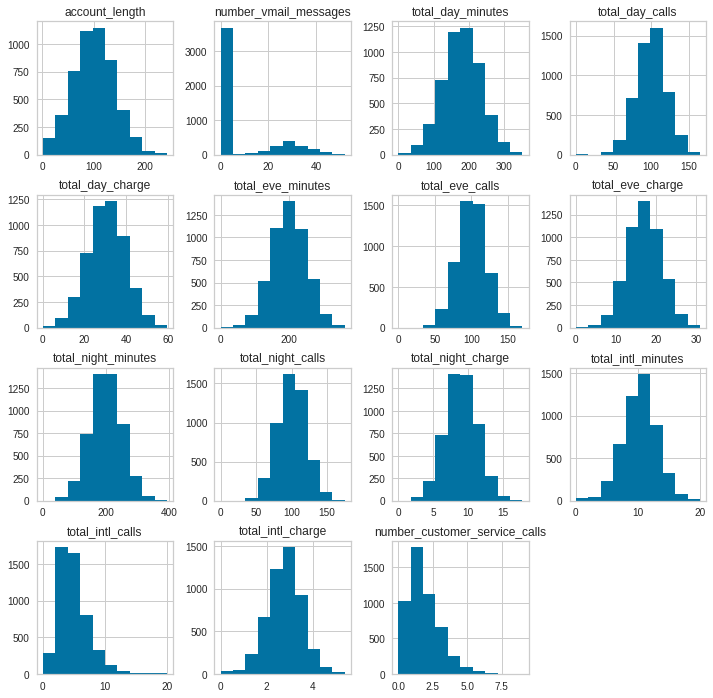

In [ ]:
explore.hist(figsize = (12,12))
plt.show()

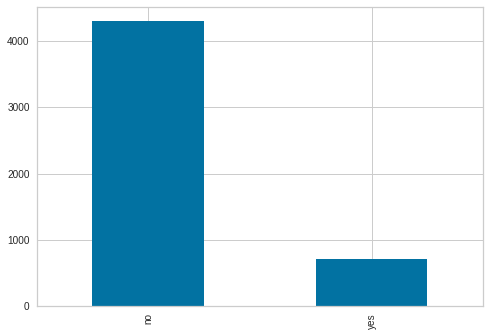

In [ ]:
explore.churn.value_counts().plot.bar()
plt.show()

In [ ]:
explore[explore.churn == "no"].shape[0] / explore[explore.churn == "yes"].shape[0]

6.072135785007072

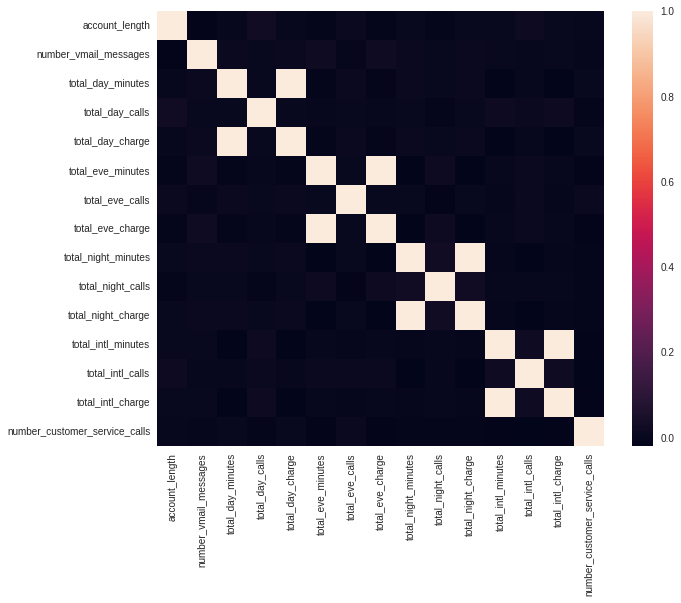

In [ ]:
plt.figure(figsize = (10,8))
sns.heatmap(explore.corr())
plt.show()

In [ ]:
#selecionando variáveis categóricas
object_features = train.select_dtypes(include="object").columns

#avaliando cardinalidade das variáveis categóricas
for feature in object_features:
    cardinality = len(explore[feature].value_counts().index)
    print(f"{feature}: {cardinality} valores únicos")
    

state: 51 valores únicos
area_code: 3 valores únicos
international_plan: 2 valores únicos
voice_mail_plan: 2 valores únicos
churn: 2 valores únicos


- As variáveis numéricas apresentam distribuição semelhante a normal. Assim, por pressupor essa distribuição aos dados, ter uma maior interpretabilidade, e requerer menos tempo de treino, a regressão logística será a primeira opção de modelo a ser testado.
- As variáveis Minutes e Charge são fortemente relacionados. Uma opção seria exclui-las e criar apenas Charge/Minutes, afim de evitar multicolinearidade.
- A variável target (churn) está desbalanceada. Para cada cliente que faz o churn outros 6 permanecem na empresa. Embora essa proporção seja esperada e reflita a realidade em problemas dessa natureza, o modelo criado pode ter problemas em aprender sobre a classe de interesse (yes) devido ao baixo número de ocorrências.
- Das features que necessitam de enconde para formato numérico, 4 são binárias ou com baixar cardinalidade (area_code, voice_mail_plan, international_plan e churn) e 1 possui alta cardinalidade (state)

## Gerando insights sobre os dados

Antes de explorar cada feature, iremos sumarizar as informações contidas em cobranças, minutos e chamadas como o total de day, eve, night e intl para cada.

In [ ]:
explore["total_charge"] = explore[[i for i in train.columns if "charge" in i]].sum(axis = 1)
explore["total_minutes"] = explore[[i for i in train.columns if "minutes" in i]].sum(axis = 1)
explore["total_calls"] = explore[[i for i in train.columns if "calls" in i]].sum(axis = 1)

### Estado

In [ ]:
churn_state_prop = RotationPropState()

In [ ]:
churn_state_prop.head()

,state,churn,count,totalState,prop
4,CA,yes,14,52,26.92
31,NJ,yes,28,112,25.00
47,WA,yes,24,98,24.49
43,TX,yes,26,116,22.41
26,MT,yes,21,99,21.21


In [ ]:
churn_state_prop.tail()

,state,churn,count,totalState,prop
39,RI,yes,7,99,7.07
0,AK,yes,5,72,6.94
29,NE,yes,6,88,6.82
11,HI,yes,5,86,5.81
45,VA,yes,6,118,5.08


<AxesSubplot:>

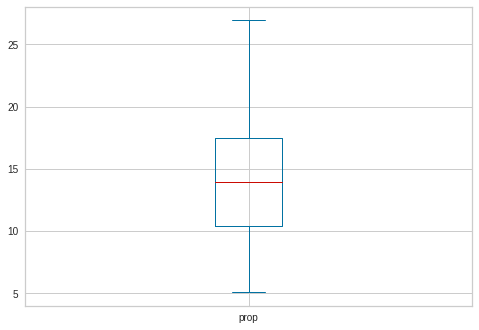

In [ ]:
churn_state_prop["prop"].plot.box()

In [ ]:
churn_state_prop["prop"].describe()

count   51.00
mean    14.11
std      5.02
min      5.08
25%     10.44
50%     13.92
75%     17.44
max     26.92
Name: prop, dtype: float64

In [ ]:
# 75% das proporções estao abaixo de 17.44
high_churn_states = list(churn_state_prop[churn_state_prop["prop"] >= 17.44]["state"].values)
high_churn_states

['CA', 'NJ', 'WA', 'TX', 'MT', 'MD', 'NV', 'ME', 'KS', 'OK', 'SC', 'NY', 'MI']

In [ ]:
# 25% das proporções estão abaixo de 10.25
low_churn_states = list(churn_state_prop[churn_state_prop["prop"] <= 10.25]["state"].values)
low_churn_states

['DC', 'AZ', 'VT', 'WY', 'LA', 'IL', 'WI', 'RI', 'AK', 'NE', 'HI', 'VA']

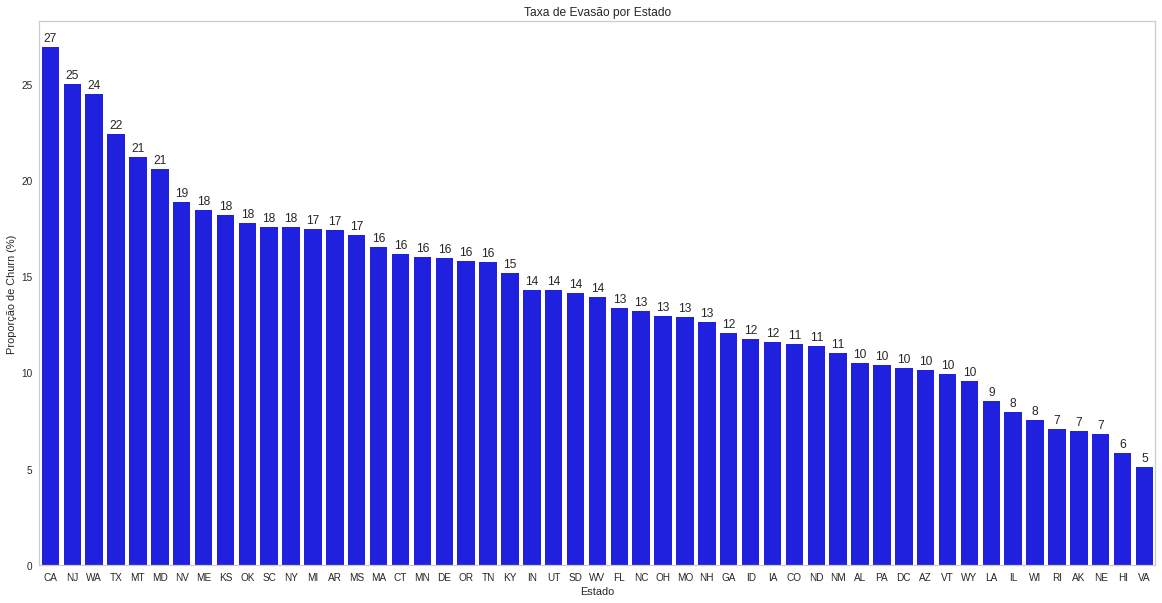

In [ ]:
BarplotState(churn_state_prop, y = "prop", y_label = "Proporção de Churn (%)", title = "Taxa de Evasão por Estado", bars_annotate = True)

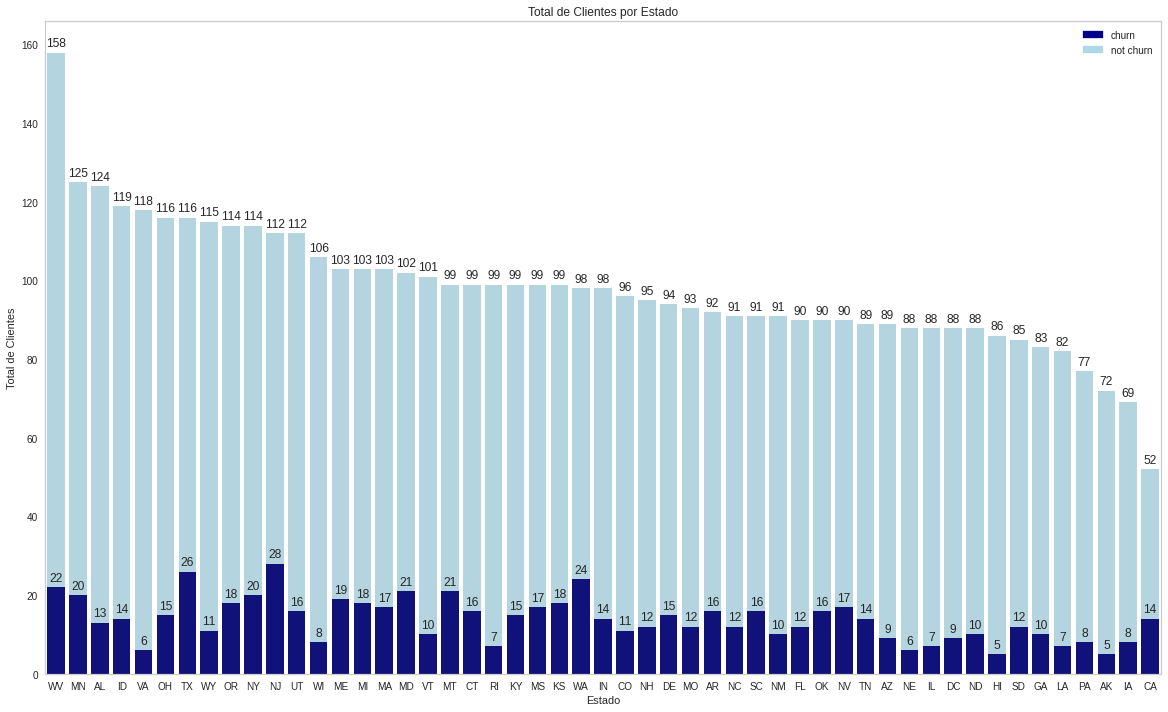

In [ ]:
StackedBarplotState()

#### Cobrança por Estado

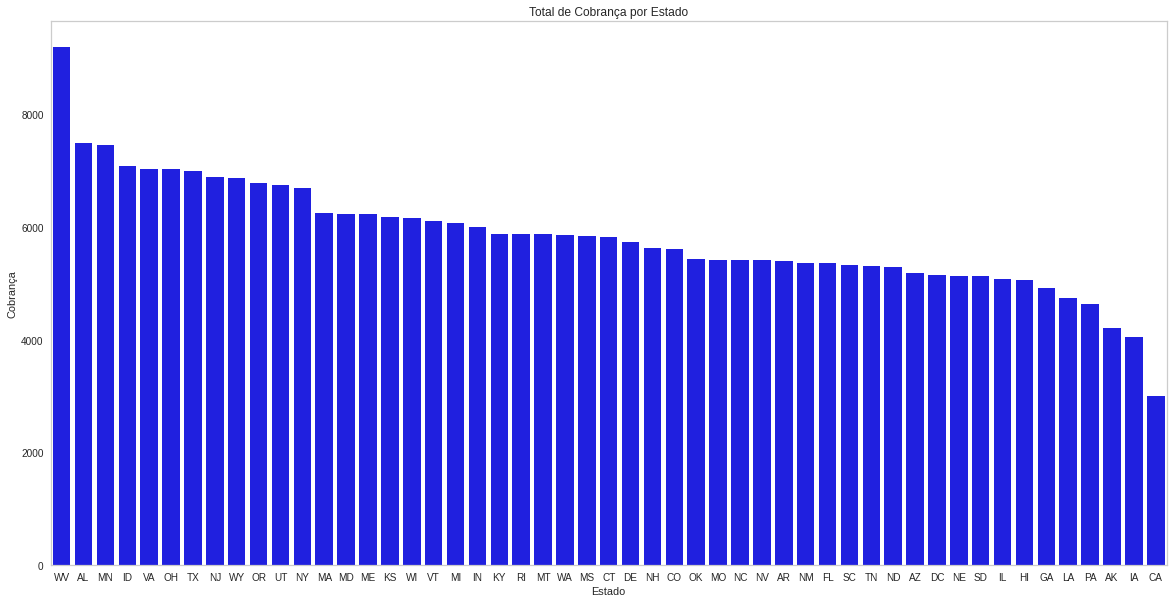

In [ ]:
state_charge = SumFeatureState("total_charge")
BarplotState(state_charge, y = "total_charge", y_label = "Cobrança", title = "Total de Cobrança por Estado")

#### Minutos em Chamadas por Estado

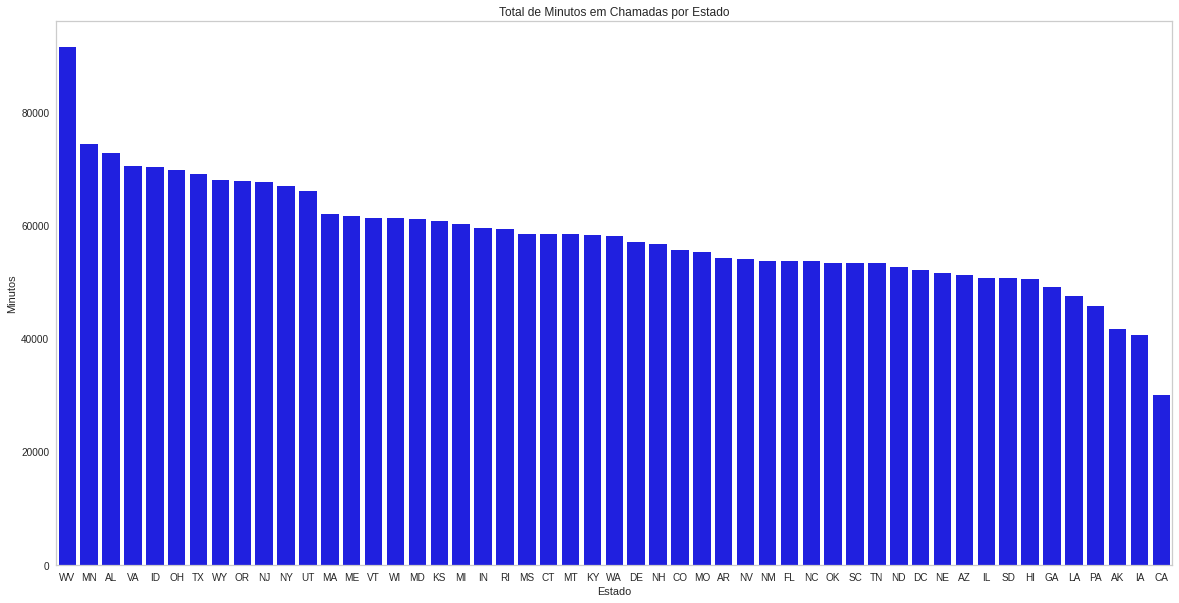

In [ ]:
state_minutes = SumFeatureState("total_minutes")
BarplotState(state_minutes, y = "total_minutes", y_label = "Minutos", title = "Total de Minutos em Chamadas por Estado")

#### Número de Chamadas por Estado

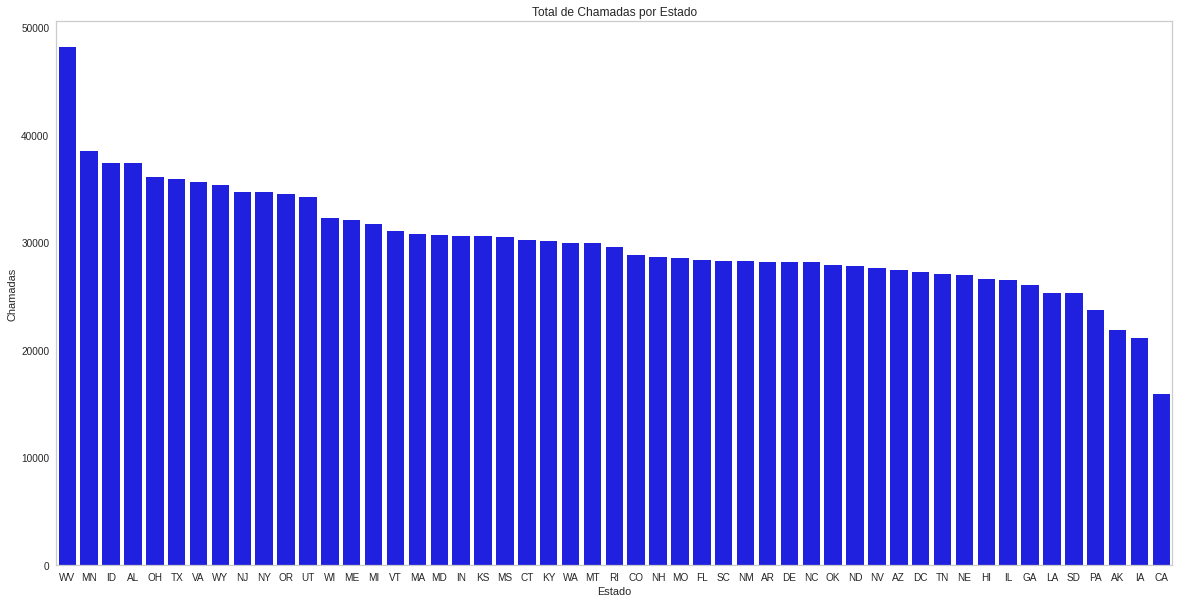

In [ ]:
state_minutes = SumFeatureState("total_calls")
BarplotState(state_minutes, y = "total_calls", y_label = "Chamadas", title = "Total de Chamadas por Estado")

- Estados com maiores taxa de churn: CA, NJ, WA, TX, MT, MD, NV, ME, KS, OK, SC, NY, MI
- Estados com menores taxa de churn: DC, AZ, VT, WY, LA, IL, WI, RI, AK, NE, HI, VA

- Califórnia (CA) : Estado com menor número de clientes (52) e maior taxa de churn (27%)

- Virgínia Ocidental (WV): Estado com maior número de clientes (158) e taxa de churn próximo a média (14%)

- Virgínia (VA): Estado com menor taxa de churn (5%) e um dos mais rentáveis (5a maior taxa de cobrança total) 

### Cobranças, Minutos e Chamadas

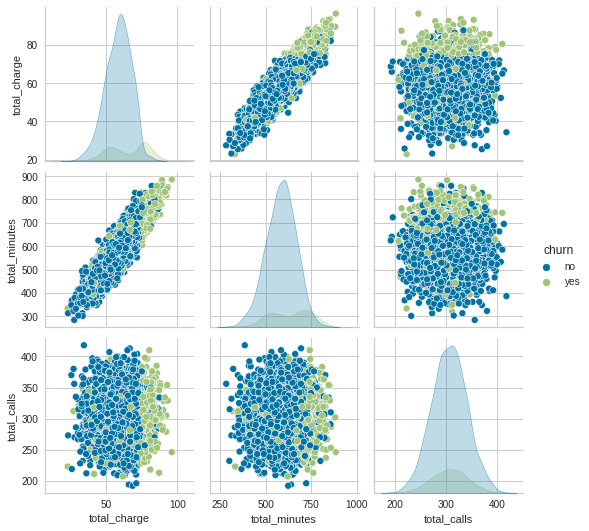

In [ ]:
sns.pairplot(data=explore[["total_charge","total_minutes","total_calls","churn"]], hue="churn")
plt.show()

- No geral, clientes que fazem o churn são aqueles que passam mais minutos em chamdas gerando mais cobranças, ou seja, justamente aqueles que agregam mais valor a empresa.
- Não há relação entre número de chamadas e minutos, ou seja, pessoas que passam muito tempo no telefone não necessariamente fazem muitas chamadas.

### Hábitos

In [ ]:
def habits(feat_name):
    
    features = [i for i in explore.columns if feat_name in i]
    
    features.remove("total_" +feat_name) # exlui o agregado, quero avaliar justamente os periodos do dia 
    
    explore.groupby("churn")[features].mean().plot.bar()

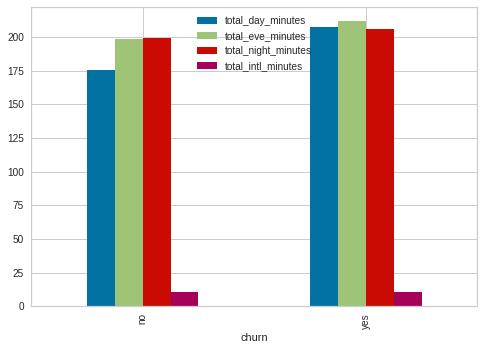

In [ ]:
habits("minutes")

- 

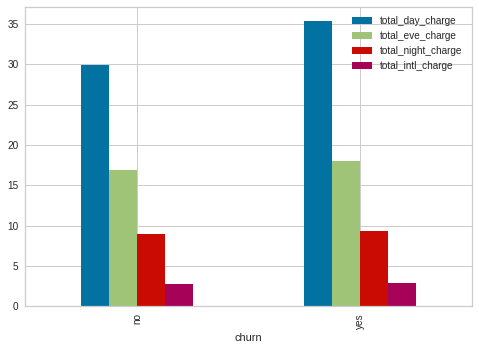

In [ ]:
habits("charge")

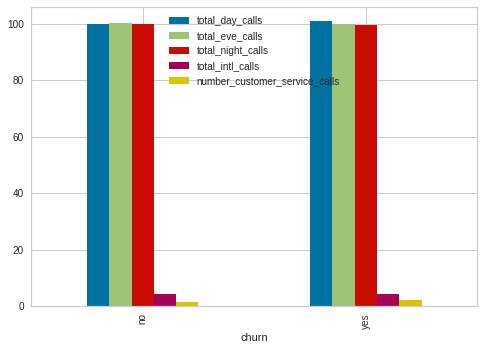

In [ ]:
habits("calls")

- O número médio de chamadas foi praticamente o mesmo independente do horário do dia entre os dois grupos

- O periódo de maior cobranças foi pela manhã, sendo significativamente maior nos usuários que fizeram churn.

- O número médio de minutos em chamadas pela manhã foi inferior a os outros periodos do dia nos usuários que não fizeram churn 

- Clientes que não realizam o churn passam menos minutos em chamadas pela manhã (em média) do que os que realizam churn

- Clientes que realizam o churn fornecem um maior retorno a empresa, na forma de cobranças, do que os que permanecem, especialmente durante o periodo da manhã

### Planos adquiridos

In [ ]:
#selecionando apenas os que cancelaram
exploreYes = explore[explore.churn == "yes"].reset_index(drop=True)

#verificando proporção dos clientes que cancelaram com relação aos planos
plan = exploreYes.groupby(["churn","international_plan","voice_mail_plan"]).count().iloc[:,0].reset_index().rename(columns = {"state":"count"})
plan

,churn,international_plan,voice_mail_plan,count
0,yes,no,no,452
1,yes,no,yes,56
2,yes,yes,no,153
3,yes,yes,yes,46


In [ ]:
plan["label"] = ["Nenhum Plano", "Apenas Correio de Voz", "Apenas internacional", "Ambos os planos"]
plan

,churn,international_plan,voice_mail_plan,count,label
0,yes,no,no,452,Nenhum Plano
1,yes,no,yes,56,Apenas Correio de Voz
2,yes,yes,no,153,Apenas internacional
3,yes,yes,yes,46,Ambos os planos


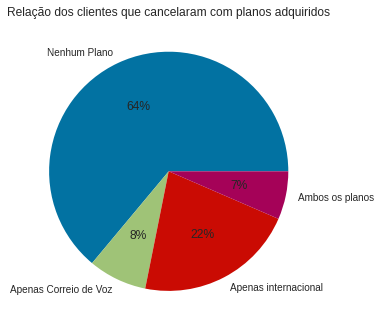

In [ ]:
plt.figure()
plt.title("Relação dos clientes que cancelaram com planos adquiridos")
ax = plt.pie(plan["count"], labels=plan["label"], autopct= '%.0f%%')
plt.show()

- Grande parte dos clientes que abandonam a companhia não tem nenhum dos planos ofertados. Estratégia: tornar esses planos mais acessíveis e divulgá-los
- Menos de 10% dos clientes que abandoman a compainha tem os dois planos Quebrar barreira de entrada em planos
- 22% dos clientes que fazem o churn tem apenas o plano internacional

### Meses que o cliente está com o provedor de telecomunicações atual

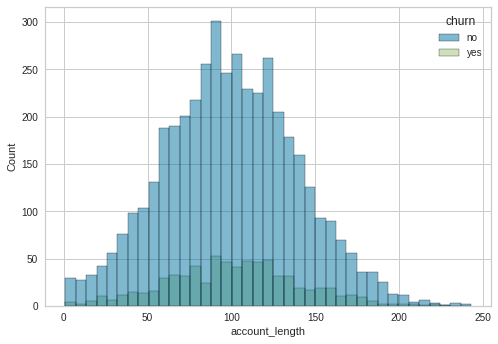

In [ ]:
sns.histplot(data= explore, x = "account_length", hue = "churn")
plt.show()

<AxesSubplot:xlabel='churn', ylabel='account_length'>

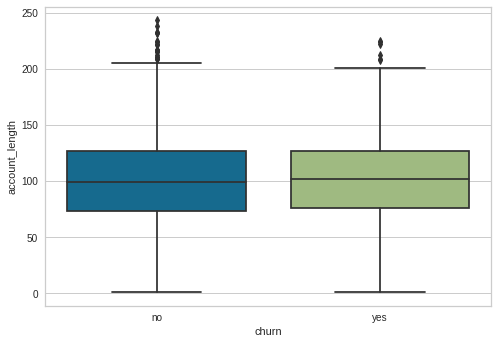

In [ ]:
sns.boxplot(data=explore, x = "churn", y="account_length")

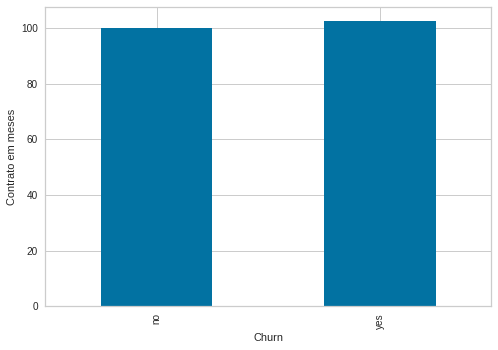

In [ ]:
explore.groupby("churn")["account_length"].mean().plot.bar()
plt.ylabel("Contrato em meses")
plt.xlabel("Churn")
plt.show()

- Clientes tendem a passar bastante tempo em média (~100 meses) antes de realizar o churn
- O numéro de meses é similar entre os clientes churn vs nao churn 

### Número de ligações para atendimento ao cliente

<AxesSubplot:xlabel='churn', ylabel='number_customer_service_calls'>

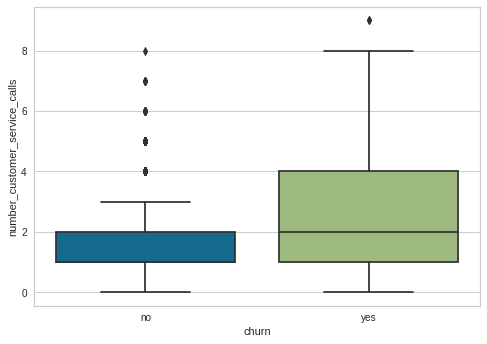

In [ ]:
sns.boxplot(data=explore, x = "churn", y="number_customer_service_calls")

- Clientes que fazem o churn realizam mais chamadas para atendimento ao cliente em relação aos clientes que permanecem. Pode ser um indicio importantede churn

# Machine Learning

## Definição das métricas de avaliação

Como estamos interessados em prever a probabilidade de um cliente realizar churn (classe positiva e minoritária), as métricas avaliadas serão a **revocação** e **precisão**, sumarizadas pela **área sobre a curva recall-precision (AP)**.

Algumas considerações:

- Curva ROC tende a subestimar ou superestimar as probabilidades em caso de datasets desbalanceados e leva em conta a especificidade (o quão bem a classe negativa é prevista, o que não nos interessa).

- Acurácea não é uma métrica confiável em casos de classes desbalanecadas. Um classificador simples que preveja sempre a classe majoritária acabaria apresentando uma alta acurácea apenas 

- No atual contexto precisamos evitar a todo custo os erros falso negaitvos (FN), cliente fez o churn e foi classificado pelo modelo como não churn. Ou seja, é obrigatório um alto recall (identificar a maior parte dos positivos possíveis).

- Idealmente também precisamos de uma alta precisão (quantos dos positivos identificados são realmente positivos).

- Entretanto, um modelo com alto recall (identifica bem a classe positiva) e baixa precisão (muitos dos positivos classificados não são de fato positivos) não é de todo ruim, fazendo uma analogia seria como uma rede de pesca grande que apesar de pegar todos os peixes no lago também acaba trazendo muito lixo junto.

- A justificativa é que, com relação aos erros do modelo, é menos custoso para empresa classificar um cliente que não fez churn como um que fez (Falso Positivo) do que classificar um cliente que fez churn como um que não fez (Falso Negativo).

- No primeiro caso, o que pode acontecer é direcionar uma campanha personalizada para um cliente que na verdade não estaria propenso a sair, o que pode levar a um aumento de sua satisfação. Em contrapartida, na segunda opção o cliente encerraria seu contrato sem que a empresa tivesse oportunidade de agir, uma vez que ele estaria classificado como não propenso a churn.

## Pré-processamento

Aqui, voltaremos a tratar os conjuntos de treino e teste separadamente, lembrando que a mesma alteração deve ser realizada nos dois conjuntos de forma independete afim de evitar leakage. Primeiro, removemos a variável Id por não ser informativa para o modelo. 

O pré-processamento consistiu no encode das features categoricas, usando a função a map no caso das binárias e o OneHotEncoder para as com cardinalidade superior a 2. Essa etapa é necessária pois modelos de machine learning trabalham melhor com inputs e outputs númericos para realizar previsões. Já as features númericas foram padronizadas com a classe StandardScaler. Essa etapa não é obrigatória, entretanto alguns modelos como o KNN, Regressão Logística e as SVMs são sensíveis a escala dos dados.

Posteriormente, como se trata de um problema de aprendizado supervisionado, a variável alvo, a que queremos prever (y), foi separada das features preditoras (X).

Por fim, os dados de treino foram divididos em treino (80%) e validação (20%) com amostragem estratificada, ou seja, manteve aproximadamente a mesma proporção 6 not churn para 1 churn da população. Essa separação se deu afim de ter um conjunto intermediário para selecionar o modelo e avaliar as tentativas de melhoria desse (feature engineering e selection, tunning de hiperparâmetros, SMOTE...) deixando os dados de teste apenas para avaliação final com o modelo definitivo já treinado nos dados de treino + validação.

In [5]:
#remover coluna de índice
to_drop = ["Unnamed: 0"]
train.drop(to_drop, axis = 1, inplace=True)
test.drop(to_drop, axis = 1, inplace=True)

#enconding de variáveis binárias
to_binarize = train.select_dtypes(include="object").columns[2:] #selecionando features binárias
dic = {"no":0,"yes":1}
for i in to_binarize:
    train[i] = train[i].map(dic)
    test[i] = test[i].map(dic)
    
#selecionando colunas categoricas    
to_one_hot = list(train.select_dtypes(include="object").columns[:2]) #exceto as binárias (já foram codificadas com a função map)

#selecionando colunas numéricas
to_scaler = list(train.select_dtypes(include=np.number).columns)
to_scaler.remove("churn") #exceto a target que não deve ser normalizada

#definindo pipeline de pré-processamento
cat_pipe = OneHotEncoder(sparse = False)
num_pipe = StandardScaler()
ct = make_column_transformer(
    (cat_pipe, to_one_hot),
    (num_pipe, to_scaler)
)

In [6]:
#Separando as features preditoras (X) da target (y)
X = train.drop("churn", axis = 1)
y = train["churn"]

X_test = test.drop("churn", axis = 1)
y_test = test["churn"]

In [7]:
# Separando os dados de treino em treino (80%) e validação (20%)
X_train,X_val,y_train,y_val = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

## Seleção do Modelo

Para a seleção do modelo baseline, as probabilidades obtidas pela validação cruzada (10 folds) nos dados de treino e as probabilidades obtidas pelo modelo treinado nos dados de treino e avaliado no conjunto de validação foram utilizadas para medir o score da average_precision_score nesses dois conjuntos com diferentes modelos.

Modelos ensemble (combinações de modelos) tendem a ter uma alta variância (se adequam mais aos dados) em contrapartida são menos interpretáveis e requerem maior tempo e recursos computacionais para treino. Dois representantes desse grupo foram testados: as florestas aleátorias ou Random Forest, conjunto de árvore de decisões que aprendem de forma independente e  em paralelo (Boosting) e o Extreme Gradient Boosting Algorithm ou XGBoost, onde o aprendizado acontece de forma sequencial, de forma que cada modelo aprende com os erros do anterior (Bagging).

A Regressão Logística também foi testada. Por se tratar de um modelo de fácil interpretação, e que requer um menor tempo de treino essa foi a primeira opção de modelo. Também foi testada a SVM

In [ ]:
# Definindo labels e instâncias dos modelos
labels = ["Logit", "RF", "XGB", "SVM"]
models = []
models.append(LogisticRegression(n_jobs=-1,random_state=42))
models.append(RandomForestClassifier(random_state=42))
models.append(XGBClassifier(verbosity = 0, random_state=42,  use_label_encoder=False, eval_metric = "aucpr"))
models.append(SVC(probability=True, random_state=42))

# Definindo numéro de folds para validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Tempo de execução: 21.3697 segundos ---


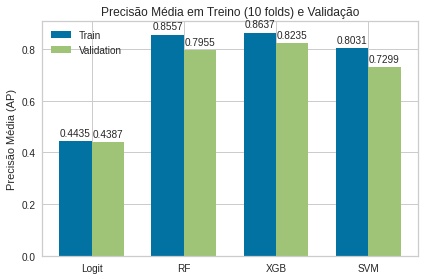

In [ ]:
#instanciando classe para seleção do modelo
em_baseline = evaluate_models(X_train,y_train,X_val,y_val)

#Chamando métodos da classe para treinar os modelos nos dados de treino e validação e plotar resultados
em_baseline.get_score(labels,models,ct,cv)
em_baseline.plot_scores()

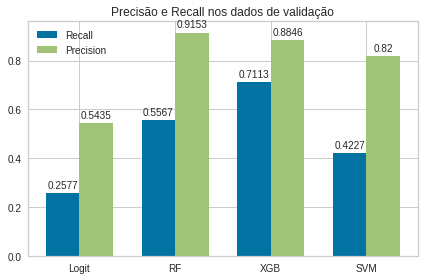

In [ ]:
em_baseline.show_class_report()

Apesar da Regressão Logistica ter sido o modelo que melhor generalizou as previsões em treino e validação (apresentou menor diferença entre treino e validação), sua performance foi muito abaixo das dos demais. Random Forest, XGB e a SVM apresentaram ótimos scores AP. Entretanto, por ter o maior recall para a classe 1 (clientes que realizam o churn), o XGB foi o modelo escolhido.


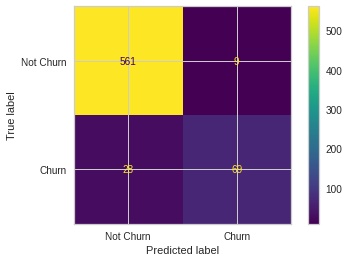

In [ ]:
#Re-treinando o XGB 
baseline = make_pipeline(ct, models[2])
baseline.fit(X_train, y_train)

#Obtendo a Confusion Matrix para avaliar os erros do modelo
cm = confusion_matrix(y_val, baseline.predict(X_val))
display = ConfusionMatrixDisplay(cm, display_labels=["Not Churn", "Churn"])
display.plot()
plt.show()

Temos portanto um modelo baseline (XGB) com:
- AP Treino (10 folds): 0.8637
- AP Validação: 0.8235
- Recall (class 1): 0.7113
- Precisão (class 1): 0.8846
- TP (True Positives): 69
- FN (False Negatives): 28

Para uma primeira tentativa, são métricas bem interessantes. Entretanto, tentaremos melhorá-las.

## Feature Engineering

Muitas vezes as features originais não são as que melhor refletem o problema de negócio. O processo de identificar features que sejam relevantes para o modelo é uma das etapas mais importantes dentro de um projeto de Data Science. Uma das formas de alcançar isso é combinar features já existentes em novas features que possam complementar a informação já disponível.

Aqui, as features criadas envolvem o total de cobranças, minutos e chamadas, independente do périodo do dia. Assim, além de termos informações mais espécificas sobre o comportamento de cada cliente, discriminada por day, evening e night, também teriamos uma prespectiva mais geral com o total desses atributos principais.

Também é notório que existem situações, sejam elas geográficas ou temporais, onde o custo varia e o minuto em chamada acaba sendo mais caro ou barato. Para tentar representar essa informação criaremos a feature recharge/minute.

Diversas outras combinações de features podem ser obtidas e por isso é importante conhecer o máximo possível o contexto do problema para poder criar as melhores possíveis.

In [6]:
train_fe = train.copy()
test_fe = test.copy()

In [28]:
#criando novas features em treino
charge = train_fe[[i for i in train_fe.columns if "charge" in i]].sum(axis=1)
minutes = train_fe[[i for i in train_fe.columns if "minutes" in i]].sum(axis=1)
calls = train_fe[[i for i in train_fe.columns if "calls" in i]].sum(axis=1)

train_fe["recharge_total"] = charge
train_fe["minutes_total"] = minutes
train_fe["calls_total"] = calls
train_fe["rechargesPerMinute"] = charge / minutes

In [29]:
# Criando novas features em teste
charge = test_fe[[i for i in test_fe.columns if "charge" in i]].sum(axis=1)
minutes = test_fe[[i for i in test_fe.columns if "minutes" in i]].sum(axis=1)
calls = test_fe[[i for i in test_fe.columns if "calls" in i]].sum(axis=1)

test_fe["recharge_total"] = charge
test_fe["minutes_total"] = minutes
test_fe["calls_total"] = calls
test_fe["rechargesPerMinute"] = charge / minutes

In [87]:
#shape dos dados
print("Antes: " )
print(f"Treino: {train.shape[0]} linhas e {train.shape[1]} colunas")
print(f"Teste: {test.shape[0]} linhas e {test.shape[1]} colunas")

print("\n\nDepois: ")
print(f"Treino_fe: {train_fe.shape[0]} linhas e {train_fe.shape[1]} colunas")
print(f"Teste_fe: {test_fe.shape[0]} linhas e {test_fe.shape[1]} colunas")

Antes: 
Treino: 3333 linhas e 20 colunas
Teste: 1667 linhas e 20 colunas


Depois: 
Treino_fe: 3333 linhas e 24 colunas
Teste_fe: 1667 linhas e 24 colunas


In [9]:
# Separando o target (y) das features preditoras (X), considerando os dados com as novas features
X = train_fe.drop("churn", axis = 1)
y = train_fe["churn"]

X_test = test_fe.drop("churn", axis = 1)
y_test = test_fe["churn"]

In [10]:
# Separando os dados de treino em treino (80%) e validação (20%) considerando as novas features criadas
X_train,X_val,y_train,y_val = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [11]:
#refazer pipeline de pre-processamento acrescentando as novas colunas

#selecionando colunas categoricas para One Hot Encoder    
to_one_hot = list(train_fe.select_dtypes(include="object").columns[:2])

#selecionando colunas numéricas para padronização
to_scaler = list(train_fe.select_dtypes(include=np.number).columns)
to_scaler.remove("churn")

#definindo pipelines e column transformer
cat_pipe = OneHotEncoder(sparse = False)
num_pipe = StandardScaler()
ct = make_column_transformer(
    (cat_pipe, to_one_hot),
    (num_pipe, to_scaler)
)

Tempo de execução: 24.3380 segundos ---


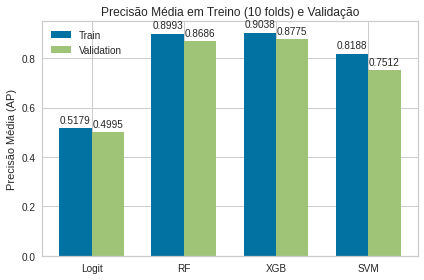

In [ ]:
# Avaliar os modelos com as novas features
em_fe = evaluate_models(X_train,y_train,X_val,y_val)
em_fe.get_score(labels,models,ct,cv)
em_fe.plot_scores()

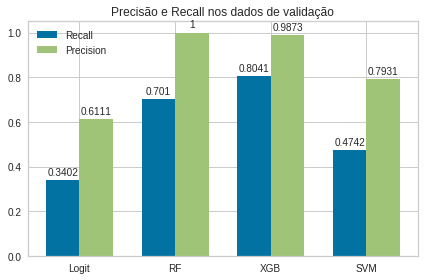

In [ ]:
em_fe.show_class_report()

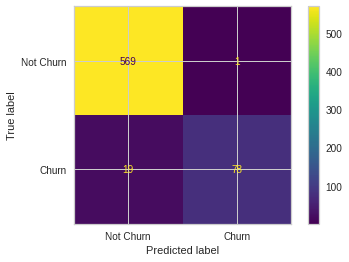

In [ ]:
# Obtendo novamente a Confusion Matrix
baseline_FE = make_pipeline(ct, models[2])
baseline_FE.fit(X_train, y_train)

cm = confusion_matrix(y_val, baseline.predict(X_val))
display = ConfusionMatrixDisplay(cm, display_labels=["Not Churn", "Churn"])
display.plot()
plt.show()

Houve uma melhoria considerável apenas com o acréscimo das novas features em todo os modelos. Para o XGB as aletrações em relação a pontuação baseline foram de:


- AP score cross validation (train): 0.8637 -> 0.9038
- AP score validation: 0.8235 -> 0.8775
- Recall (class 1): 0.7113 -> 0.8041
- Precision (class 1): 0.8846 -> 0.9873
- TP (True Positives): 69 -> 78
- FN (False Negatives): 28 -> 19



## Tratando Desbalanceamento nos Dados 

Caso o modelo seja treinado com dados desbalanceados, é possível que ele aprenda bastante sobre a classe majoritária, no atual caso, clientes que permanecem na empresa e pouco sobre a classe minoritária, clientes que fazem o churn.

Existem diversas formas de tentar diminuir os efeitos do desbalanceamento em um dataset. Aqui iremos testar duas delas: gerar observações sintéticas com SMOTE e atribuir pesos diferentes aos erros do modelo usando o parâmetro scale_pos_weight do XGB. Por fim, compará-las com o modelo sem nenhum tratamento do desbalanceamento para verificar qual das estratégias apresentou melhor performance.



In [ ]:
#inicializando listas vazias que irão receber os resultados
bl_train = []
bl_val = []
bl_index = ["None","SMOTE","Weights"]

clf = XGBClassifier(verbosity = 0, random_state=42,  use_label_encoder=False, eval_metric = "aucpr")
clf_weight = XGBClassifier(verbosity = 0, random_state=42,  use_label_encoder=False, eval_metric = "aucpr",
                    scale_pos_weight = 6)

normal_pipe = make_pipeline(ct, clf)
weight_pipe = make_pipeline(ct, clf_weight)
SMOTE_pipe = imbpipeline(ct, SMOTE(), clf)

## None - sem balanceamento
prob = cross_val_predict(normal_pipe, X_train, y_train, cv = cv, n_jobs=-1, method="predict_proba")[:,1]
cv_none = average_precision_score(y_train, prob)
bl_train.append(round(cv_none,3))

normal_pipe.fit(X_train, y_train)
val_none = average_precision_score(y_val, normal_pipe.predict_proba(X_val)[:,1])
bl_val.append(round(val_none,3))

#SMOTE
prob = cross_val_predict(SMOTE_pipe, X_train, y_train, cv = cv, n_jobs=-1, method="predict_proba")[:,1]
cv_SMOTE = average_precision_score(y_train, prob)
bl_train.append(round(cv_SMOTE,3))

SMOTE_pipe.fit(X_train, y_train)
val_SMOTE = average_precision_score(y_val, SMOTE_pipe.predict_proba(X_val)[:,1])
bl_val.append(round(val_SMOTE,3))

#Weitgh
prob = cross_val_predict(weight_pipe, X_train, y_train, cv = cv, n_jobs=-1, method="predict_proba")[:,1]
cv_weight = average_precision_score(y_train, prob)
bl_train.append(round(cv_weight,3))

weight_pipe.fit(X_train, y_train)
val_weight = average_precision_score(y_val, weight_pipe.predict_proba(X_val)[:,1])
bl_val.append(round(val_weight,3))

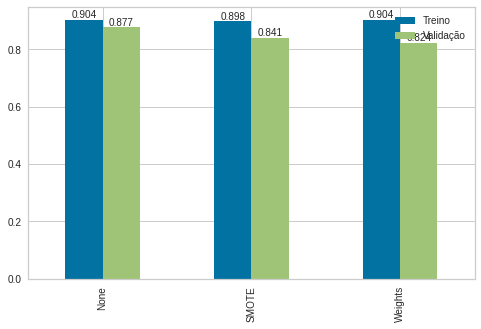

In [ ]:
fig, ax = plt.subplots()
bar = pd.DataFrame({"Treino": bl_train, "Validação":bl_val}, index = bl_index).plot.bar(ax = ax, figsize = (8,5))
ax.bar_label(bar.containers[0])
ax.bar_label(bar.containers[1])
plt.show()

Podemos concluir que a melhor performance foi do modelo sem tratamento para desbalanceamento. Logo, o desbalanceamento não foi suficiente para afetar negativamente o XGB.

## Tunning

Para ajuste dos hiperparâmetros, a estratégia utilizada foi a otimização bayesiana com o scikit-optimize. Falei um pouco sobre a diferença desse método para o grid search anteriormente.

numéro de árvores (n_estimators)
contribuição de cada árvore (learning_rate)
o tamanho de cada árvore (max_depth)
fração das features escolhidas aleatóriamente para cada árvore (subsample)


In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
clf = XGBClassifier(verbosity = 0, random_state=42,  use_label_encoder=False, eval_metric = "aucpr")


pipe_num = make_pipeline(StandardScaler())
pipe_cat = make_pipeline(OneHotEncoder(sparse = False))

ct = make_column_transformer(
    (pipe_num, to_scaler),
    (pipe_cat, to_one_hot)
)

space = [
    Integer(300,1000, name="n_estimators"),
    Real(0,1, name="learning_rate"),
    Integer(4,8, name="max_depth"),
    Integer(0,1, name="subsample")]

final_pipe = make_pipeline(ct, clf)

@use_named_args(space)
def objective(**params):
    final_pipe[1].set_params(**params)
    return -np.mean(cross_val_score(final_pipe, X_train, y_train, cv=cv, scoring="average_precision"))

In [ ]:
start_time = time.time()

gp = gp_minimize(objective,space, random_state=0, n_jobs=-1)

#tempo de execução
print(f"--- {(time.time() - start_time):.4f} seconds ---")

--- 2676.5263 seconds ---


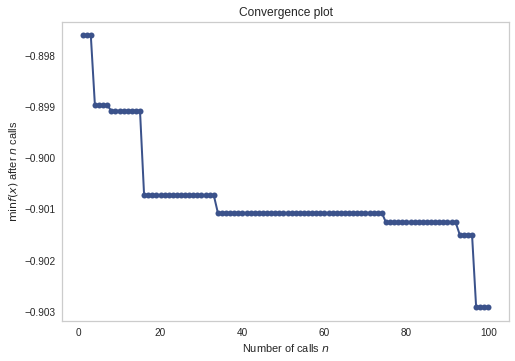

In [ ]:
plot_convergence(gp)
plt.show()

In [ ]:
abs(gp.fun)

0.9029213390946562

In [ ]:
gp.x

[300, 0.6944840730993349, 8, 1]

In [99]:
### Validação

cat_pipe = OneHotEncoder(sparse = False)
num_pipe = StandardScaler()
ct = make_column_transformer(
    (cat_pipe, to_one_hot),
    (num_pipe, to_scaler)
)

clf = XGBClassifier(n_estimators = 300, learning_rate = 0.6944, max_depth=8, subsample=1,
                    verbosity = 0, random_state=42,  use_label_encoder=False, 
                    eval_metric = "aucpr")

final_pipe = make_pipeline(ct,clf)

prob = cross_val_predict(final_pipe, X_train, y_train, cv = cv, n_jobs=-1, method="predict_proba")[:,1]

train_score = average_precision_score(y_train, prob)

final_pipe.fit(X_train,y_train)

val_score = average_precision_score(y_val, final_pipe.predict_proba(X_val)[:,1])

In [ ]:
(train_score, val_score) ##avaliar a cm disso

(0.9031814715111705, 0.8730823676887736)

Após 100 iterações o melhor score foi de 0.9031 nos dados de treino e 0.8730 em validação com a combinação de hiperparâmetros abaixo:

- n_estimators = 300
- learning_rate = 0.6944
- max_depth = 8
- subsample = 1


## Feature Selection

- AP score cross validation (train): 0.8637 -> 0.9038
- AP score validation: 0.8235 -> 0.8775
- Recall (class 1): 0.7113 -> 0.8041
- Precision (class 1): 0.8846 -> 0.9873
- TP (True Positives): 69 -> 78
- FN (False Negatives): 28 -> 19

In [95]:
start_time = time.time()
fs_train = []
fs_val = []
for n in range(2,ct.fit_transform(X_train).shape[1],4): 
    
    
    final_pipe = make_pipeline(ct, SelectFromModel(clf, threshold= -np.inf, max_features=n), clf)
    
    
    prob = cross_val_predict(final_pipe, X_train, y_train, cv = cv, n_jobs=-1, method="predict_proba")[:,1]

    train_score = average_precision_score(y_train, prob)

    fs_train.append(train_score)

    final_pipe.fit(X_train,y_train)

    val_score = average_precision_score(y_val, final_pipe.predict_proba(X_val)[:,1])

    fs_val.append(val_score)
    
    
    print(f"{n} features: Train - {train_score:.4f} | Val - {val_score:.4f}")
    
#tempo de execução
print(f"Tempo de execução: {(time.time() - start_time):.4f} Segundos")

2 features: Train - 0.5599 | Val - 0.5584
6 features: Train - 0.8615 | Val - 0.8706
10 features: Train - 0.9035 | Val - 0.8725
14 features: Train - 0.9039 | Val - 0.8798
18 features: Train - 0.8977 | Val - 0.8894
22 features: Train - 0.8992 | Val - 0.8775
26 features: Train - 0.9020 | Val - 0.8731
30 features: Train - 0.9032 | Val - 0.8731
34 features: Train - 0.9032 | Val - 0.8731
38 features: Train - 0.9032 | Val - 0.8731
42 features: Train - 0.9032 | Val - 0.8731
46 features: Train - 0.9032 | Val - 0.8731
50 features: Train - 0.9032 | Val - 0.8731
54 features: Train - 0.9032 | Val - 0.8731
58 features: Train - 0.9032 | Val - 0.8731
62 features: Train - 0.9032 | Val - 0.8731
66 features: Train - 0.9032 | Val - 0.8731
70 features: Train - 0.9032 | Val - 0.8731
74 features: Train - 0.9032 | Val - 0.8731
Tempo de execução: 527.3365 Segundos


<AxesSubplot:>

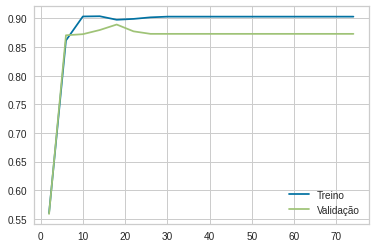

In [97]:
pd.DataFrame({"Treino": fs_train, "Validação": fs_val}, index = range(2,ct.fit_transform(X_train).shape[1],4)).plot()

## Avaliação Final nos Dados de Teste

In [12]:
clf = XGBClassifier(n_estimators = 300, learning_rate = 0.6944, max_depth=8, subsample=1,
                    verbosity = 0, random_state=42,  use_label_encoder=False, 
                    eval_metric = "aucpr")


final_pipe = make_pipeline(ct, SelectFromModel(clf, threshold= -np.inf, max_features=30), clf)

final_pipe.fit(X,y)

probs = final_pipe.predict_proba(X_test)[:, 1]

In [ ]:
average_precision_score(y_test, probs)

0.9064040808846622

In [ ]:
print(classification_report(y_test, final_pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1443
           1       1.00      0.86      0.92       224

    accuracy                           0.98      1667
   macro avg       0.99      0.93      0.96      1667
weighted avg       0.98      0.98      0.98      1667



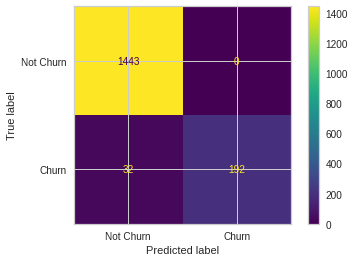

In [ ]:
  cm = confusion_matrix(y_test, final_pipe.predict(X_test))
  display = ConfusionMatrixDisplay(cm, display_labels=["Not Churn", "Churn"])
  display.plot()
  plt.show()

In [98]:
#https://www.machinelearningplus.com/waterfall-plot-in-python/

### Checkpoint 2 - Modelo Treinado

In [ ]:
#pickle.dump(final_pipe, open("data/XGB.pickle_LOCAL_LAB.dat", "wb"))
final_pipe = pickle.load(open("data/XGB.pickle_LOCAL_LAB.dat", "rb"))

In [ ]:
#pickle.dump(final_pipe, open("data/XGB.pickle.dat", "wb"))
final_pipe = pickle.load(open("data/XGB.pickle.dat", "rb"))

## Interpretando as previsões do Modelo

Importante saber com base em que o modelo faz as previs~pes

Idealmente optariamos por um modelo de facil interpretabilidade, como nao foi possivel uma vez que a performance da logit foi muot abaxio prosseguimos com o XGB que é tido como um modelo blackbox, não é possível saber 

A classe columtransformer do sklearn remove os nomes das features do dataframe e não é possível obter 

In [13]:
temp = get_feature_names(final_pipe[0])
cols = []

for i in range(len(temp)):
    cols.append(temp[i][temp[i].find("__")+2:])

In [16]:
temp[0:3]

['onehotencoder__x0_AK', 'onehotencoder__x0_AL', 'onehotencoder__x0_AR']

In [17]:
cols[0:3]

['x0_AK', 'x0_AL', 'x0_AR']

Como o shap não aceita o uso de pipelines, iremos transformar as features preditoras manualmente e treinar a mesma instancia do modelo definidia anteriormente nesses dados.

In [15]:
#precisa dessa celula nova instancia para local
XGB = clone(final_pipe[2])
X_tr = pd.DataFrame(final_pipe[0].transform(X), columns = cols)
XGB.fit(X_tr,y)

explainer = shap.Explainer(XGB)
shap_values = explainer(X_tr)

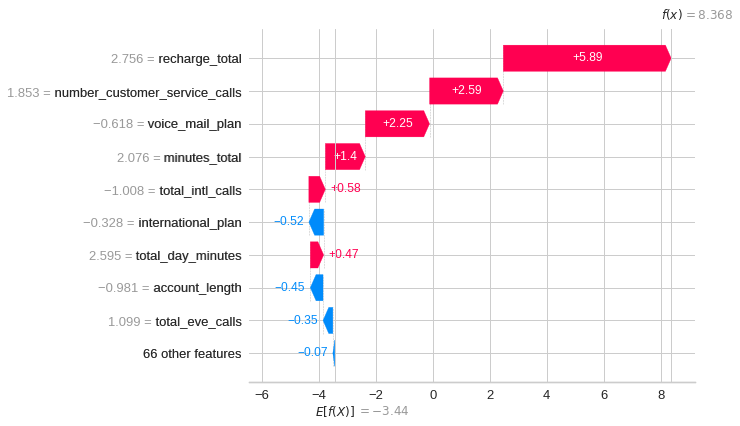

In [21]:
shap.plots.waterfall(shap_values[3322])

In [22]:
shap.initjs()
shap.plots.force(shap_values[3322], link = "logit", out_names = "kapa", feature_names=cols, matplotlib = False)  #using 1 as ref why?  ##puxa classe 1 para cima

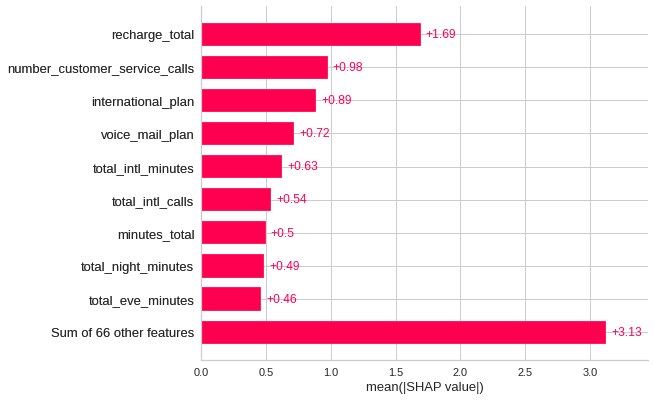

In [23]:
shap.plots.bar(shap_values)  #puxam a probabilidade da classe 1 para cima (aumentam chance de churn)

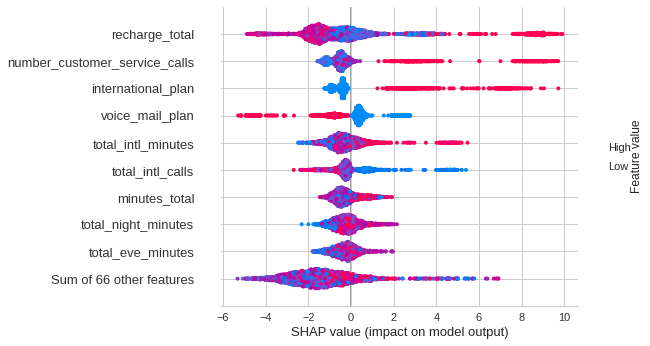

In [24]:
shap.plots.beeswarm(shap_values)

In [ ]:
# indices com churn para verificar no force plot
y[y == 1].index

Int64Index([  10,   15,   21,   33,   41,   48,   54,   57,   69,   76,
            ...
            3268, 3272, 3280, 3287, 3291, 3301, 3304, 3320, 3322, 3323],
           dtype='int64', length=483)

## Interpretação Local

In [16]:
v1 = ["AK",100,"area_code_408",0,0,0,180,100,30,201,100,17,200,100,9,10,4,2,1,58,591,304,0.09813874788494077]

In [17]:
new_data = pd.DataFrame(np.array(v1).reshape((1,-1)), columns = X.columns)

In [18]:
prob = final_pipe.predict_proba(new_data)[0][1]

In [19]:
print(f"{prob*100:.2f}")

0.00


In [20]:
#local precisa re-treinar fora do pipeline - sempre fazer copia do modelo
#X_tr = final_pipe[0].transform(X)

#XGB = clone(final_pipe[2])
#XGB.fit(X_tr, y)

new_data_tr = pd.DataFrame(final_pipe[0].transform(new_data), columns = cols)

#explainer = shap.Explainer(XGB)
shap_values = explainer(new_data_tr)

In [21]:
shap.initjs()
shap.plots.force(shap_values, link = "logit", out_names = "kapa", feature_names=None, matplotlib = False)  #using 1 as ref why?  ##puxa classe 1 para cima

In [22]:
v2 = ["CA",223,"area_code_510",1,1,39,180,100,30,201,100,17,349,161,17,19,14,5,8,69,749,375,0.09212283044058744]

In [23]:
new_data = pd.DataFrame(np.array(v2).reshape((1,-1)), columns = X.columns)

In [24]:
prob = final_pipe.predict_proba(new_data)[0][1]

In [25]:
print(f"{prob*100:.2f}")

12.65


In [26]:
new_data_tr = pd.DataFrame(final_pipe[0].transform(new_data), columns = cols)
shap_values = explainer(new_data_tr)

In [27]:
shap.initjs()
shap.plots.force(shap_values, link = "logit", out_names = "kapa", feature_names=None, matplotlib = False)  #using 1 as ref why?  ##puxa classe 1 para cima

considerações finais tecnicas 

cosideraçõe sfinais não tecnias (do problema de negocio)

grafico de cascata

## Calibrando probabilidades

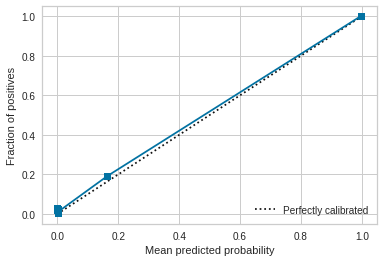

In [ ]:
prob_true,prob_pred = calibration_curve(y_test, final_pipe.predict_proba(X_test)[:,1]
                                        , n_bins=10, strategy="quantile")

disp = CalibrationDisplay(prob_true, prob_pred, final_pipe.predict_proba(X_test))
disp.plot()

In [ ]:
from yellowbrick.classifier import DiscriminationThreshold

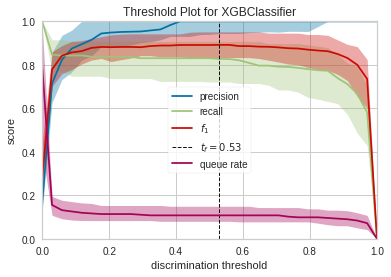

AttributeError: ignored

TypeError: ignored

In [ ]:
discrimination_threshold(final_pipe, X_test, y_test)